# Projet de reconnaissance de panneaux routiers

## Importation des librairies

Voici les librairies que nous utilisons dans le projet.

In [1]:
# LIBRAIRIES DE TORCH
import torch as torch
from torch.utils import data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.nn.functional as F

# LIBRAIRIES DE TRAITEMENT DE DONNEES
import numpy as np
import pandas as pd
from functools import reduce 

# LIBRAIRIE DE TRAITEMENT D'IMAGES
from PIL import Image

# LIBRAIRIE DE PLOT
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Importation des données

Pour commencer, nous aurons besoin d'un dictionnaire avec la signification de chaque label

In [2]:
CLASSES = { 
    0:"Limitation de vitesse (20km/h)",
    1:"Limitation de vitesse (30km/h)", 
    2:"Limitation de vitesse (50km/h)", 
    3:"Limitation de vitesse (60km/h)", 
    4:"Limitation de vitesse (70km/h)", 
    5:"Limitation de vitesse (80km/h)", 
    6:"Fin de limitation de vitesse (80km/h)", 
    7:"Limitation de vitesse (100km/h)", 
    8:"Limitation de vitesse (120km/h)", 
    9:"Interdiction de depasser", 
    10:"Interdiction de depasser pour vehicules > 3.5t", 
    11:"Intersection ou' vous etes prioritaire", 
    12:"Route prioritaire", 
    13:"Ceder le passage", 
    14:"Arret a' l'intersection", 
    15:"Circulation interdite", 
    16:"Acces interdit aux vehicules > 3.5t", 
    17:"Sens interdit", 
    18:"Danger", 
    19:"Virage a' gauche", 
    20:"Virage a' droite", 
    21:"Succession de virages", 
    22:"Cassis ou dos-d'ane", 
    23:"Chaussee glissante", 
    24:"Chaussee retrecie par la droite", 
    25:"Travaux en cours", 
    26:"Annonce feux", 
    27:"Passage pietons", 
    28:"Endroit frequente' par les enfants", 
    29:"Debouche' de cyclistes", 
    30:"Neige ou glace",
    31:"Passage d'animaux sauvages", 
    32:"Fin des interdictions precedemment signalees", 
    33:"Direction obligatoire a' la prochaine intersection : a' droite", 
    34:"Direction obligatoire a' la prochaine intersection : a' gauche", 
    35:"Direction obligatoire a' la prochaine intersection : tout droit", 
    36:"Direction obligatoire a' la prochaine intersection : tout droit ou a' droite", 
    37:"Direction obligatoire a' la prochaine intersection : tout droit ou a' gauche", 
    38:"Contournement obligatoire de l'obstacle par la droite", 
    39:"Contournement obligatoire de l'obstacle par la gauche", 
    40:"Carrefour giratoire", 
    41:"Fin d'interdiction de depasser", 
    42:"Fin d'interdiction de depasser pour vehicules > 3.5t" 
}


Ensuite nous pouvons commencer l'importation des données

### Le training dataset

In [3]:
# on commence par recolter les donnees et transformer les images en tensors
raw_data = datasets.ImageFolder("panneaux_route/Train", transform=transforms.Compose(
    [transforms.Resize((32,32)),
    transforms.ToTensor()]
))

# construisons le dataloader
train_loader = DataLoader(raw_data, batch_size=1024, shuffle=True)

### Les données de Test

Puisque les données de Test ne sont pas stockées comme les données du training, il faut aller les chercher dans le csv. Pour se faire, nous utilisons la librairie pandas. La librairie nous permet d'isoler les informations des classes et du chemin des différentes images.

In [4]:
df = pd.read_csv('panneaux_route/Test.csv', sep=',')
transformation = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

labels = list(df['ClassId'])
images = list(df['Path'])
img_lst = []

for img in images :
    img = "panneaux_route/" + img
    img_lst.append(transformation(Image.open(img)))

Avec ces données, il va falloir les transférer dans un dataset personnalisé.

In [5]:
class MyDataSet(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

Et pour finir nous devons aussi faire notre dataloader du test

In [6]:
# le dataset
test_dataset = MyDataSet(img_lst, labels)

# le dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256)

## Explorons les données

Explorons un peu les données pour savoir ce que l'on manipule

In [7]:
print(raw_data.classes)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


Comme nous pouvons le voir au-dessus, les classes qui sont répertoriées dans nos raw_data ne sont pas dans le bon ordre. Pour pallier à ce problème, nous essayerons de changer le retour des fonctions de validations et d'affichage.

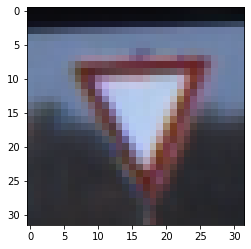

Ceder le passage


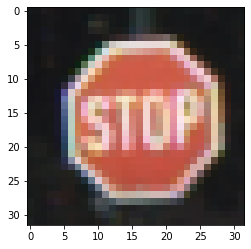

Arret a' l'intersection


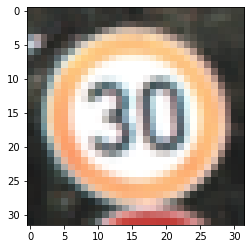

Limitation de vitesse (30km/h)


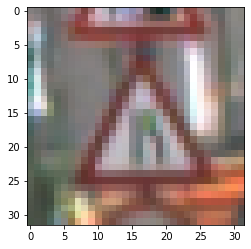

Chaussee retrecie par la droite


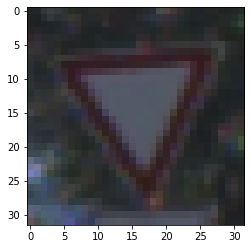

Ceder le passage


In [8]:
for images, labels in train_loader :
    for i in range(5) :
        plt.imshow(images[i].permute(1,2,0))
        plt.show()
        print(CLASSES[int(raw_data.classes[labels[i]])]) # pour palier au probleme d'ordre des classes voici ce que nous devons faire
    break

Regardons maintenant la repartition des données, en commençant par les raw_data.

In [9]:
def repartition(dico, d, total) :
    for image, label in d :
        if raw_data.classes[label] in dico :
            dico[raw_data.classes[label]] += 1
        else :
            dico[raw_data.classes[label]] = 1
        total += 1

    for key in dico :
        dico[key] = 100*(dico[key] / total)

    my_list = dico.items()
    my_list = sorted(my_list)
    x, y = zip(*my_list)

    import plotly.graph_objects as go
    fig = go.Figure(
        data=[go.Bar(x=x, y=y)],
        layout_title_text="Nombre d'images par classe (en %)",
        layout_width=1000,
        layout_height=500
    )
    fig.show()
    return x, y

In [10]:
raw_count = {}
raw_total = 0

x_r, y_r = repartition(raw_count, raw_data, raw_total)

Regardons la repartition du Test pour finir.

In [11]:
test_count = {}
test_total = 0

x_s, y_s = repartition(test_count, test_dataset, test_total)
print(test_dataset.__len__())

12630


Combinons maintenant toutes ces données, par curiosité.

In [12]:
fig = go.Figure(
    data=[
        go.Bar(name='Train / Raw', x=x_r, y=y_r),
        go.Bar(name='Test', x=x_s, y=y_s)
    ],
    layout_title_text="Nombre d'images par classe (en %)",
    layout_width=1200,
    layout_height=500
)
fig.show()

Sur ce graphique, nous voyons donc que certaines classes sont surrepresentées dans notre jeu de données de train/validation, et sous representé par rapport aux données du Test. Cela pourrait avoir une incidence sur sa capacité à reconnaître les bonnes valeurs.

## Construction du Model

### Fonctions de Validation

Nous avons codé plusieurs fonctions de validations, chacune prenant des paramètres particuliers, ou faisant des changements particuliers.

In [13]:
def validate_normal(predictions, labels) :
    nb_errors = ((predictions.argmax(1)) != labels).sum()
    return (len(predictions)-nb_errors).item()

def validate_training(data_loader, model) :
    nb_errors = 0
    nb_tests = 0
    for i, (images, labels) in enumerate(data_loader):
        output = model(images)
        nb_errors += ((output.argmax(1)) != labels).sum()
        nb_tests += len(images)
    return (100*(nb_tests-nb_errors)) / nb_tests

def validate_test(data_loader, model):
    nb_errors = 0
    nb_tests = 0
    for i, (images, labels) in enumerate(data_loader):
        output = model(images.view(-1, 3, 32, 32)).argmax(1)
        predictions = []
        for prediction in output.tolist() :
            predictions.append(raw_data.classes[prediction])

        for i in range(len(predictions)) :
            if int(predictions[i]) != int(labels[i]) :
                nb_errors += 1
        nb_tests += len(images)
    
    return (100*(nb_tests-nb_errors)) / nb_tests

### Model

Nous avons choisi de partir sur la base de LeNet5 vu en cours, mais en ajoutant certaines choses, comme des dropout ou des couches supplémentaires. Après de multiples essais, nous sommes parvenus à un meilleur score avec celui-ci.

In [14]:
class LeNet5(nn.Module):
    def __init__(self, dropout=0.0, input_canals=3):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(input_canals, 32, kernel_size=(5, 5))        # 3 * 9 * 5 * 5 + 9
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=(3, 3))      # 9 * 9 * 3 * 3 + 9
        self.dropout1 = nn.Dropout2d(p=dropout)
        self.batchnorm1 = nn.BatchNorm2d(32)                     # as attribute, for affine=True

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(4,4))        # 9 * 32 * 3 * 3 + 32
        self.conv2_1 = nn.Conv2d(64, 64, kernel_size=(3, 3))    # 32 * 32 * 3 * 3 + 32
        self.dropout2 = nn.Dropout2d(p=dropout)
        self.batchnorm2 = nn.BatchNorm2d(64)                    # as attribute, for affine=True

        self.conv3 = nn.Conv2d(64, 92, kernel_size=(3,3))       # 32 * 64 * 3 * 3 + 92
        self.conv3_1 = nn.Conv2d(92, 92, kernel_size=(2, 2))    # 64 * 64 * 3 * 23 + 92
        self.dropout3 = nn.Dropout(p=dropout)
        self.batchnorm3 = nn.BatchNorm2d(92)                    # as attribute, for affine=True

        self.fc1 = nn.Linear(92, 98)                          # 120 * 98 + 98
        self.batchnorm4 = nn.BatchNorm1d(98)

        self.fc2 = nn.Linear(98, 43)                            # 98 * 43 + 43

    def forward(self, input):                                               # B * 3 * 32 * 32  
        layer1 = F.relu(self.conv1(input))                                  # B * 9 * 28 * 28    28 car T-K+1 : (32 - 5 + 1) * (32 - 5 + 1)
        layer1_2 = F.relu(self.conv1_2(layer1))                             # B * 9 * 26 * 26
        layer2 = F.max_pool2d(layer1_2, kernel_size=(2, 2), stride=2)       # B * 9 * 13 * 13
        layer2_d = self.dropout1(layer2)
        layer2_bn = self.batchnorm1(layer2_d)

        layer3 = F.relu(self.conv2(layer2_bn))                              # B * 32 * 10 * 10
        layer3_1 = F.relu(self.conv2_1(layer3))                             # B * 16 * 8 * 8
        layer4 = F.max_pool2d(layer3_1, kernel_size=(2, 2), stride=2)       # B * 16 * 4 * 4
        layer4_d = self.dropout1(layer4)
        layer4_bn = self.batchnorm2(layer4_d)

        layer5 = F.relu(self.conv3(layer4_bn))                              # B * 120 * 2 * 2
        layer5_1 = F.relu(self.conv3_1(layer5))
        layer5_d = self.dropout3(layer5_1)
        layer5_bn = self.batchnorm3(layer5_d)     

        layer6 = F.relu(self.fc1(torch.flatten(layer5_bn,1)))               # B * 92
        layer7_bn = self.batchnorm4(layer6)       

        layer8 = self.fc2(layer7_bn)                                        # B * 43
        return layer8

Regardons combien de paramètres possède notre modèle.

In [15]:
net = LeNet5()

total_nb_par = 0
for p in net.parameters():
    total_nb_par += reduce(lambda x, y: x*y, p.shape, 1)
print("total nb parameters: ", total_nb_par)

total nb parameters:  182415


### La boucle d'apprentissage

In [16]:
def train_loop(train_loader, model, loss_map, lr=1e-3, epochs=20, weight_decay=0) :
    history = []    #for monitoring

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # nous utilisons l'optimiseur Adam vu en cours

    # boucle d'apprentissage
    for epoch in range(epochs) :
        loss_epoch = 0.
        train_acc = 0.

        model.train()

        for images, labels in train_loader :
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_map(output, labels)

            model.zero_grad()
            loss.backward()
            optimizer.step()

            loss_epoch += loss.item()
            train_acc += validate_normal(output, labels)

        # affichage des differents epochs
        model.eval()
        test_acc = validate_test(test_dataloader, model)
        train_acc = 100*train_acc/len(train_loader.dataset)
        history.append(
            {'epoch' : epoch + 1,
             'loss' : loss_epoch,
             'train_acc' : train_acc,
             'valid_acc' : test_acc})
        print(f"epoch : {epoch + 1}/{epochs}, loss = {loss_epoch:.6f}, train_acc = {train_acc}, test_acc = {test_acc}%")
    return history

In [17]:
net     = LeNet5(0.4)
history = train_loop(train_loader, net, nn.CrossEntropyLoss(), lr=0.00155, epochs=10, weight_decay=0.008)

cpu
epoch : 1/10, loss = 114.215395, train_acc = 25.79254762937081, test_acc = 46.70625494853523%
epoch : 2/10, loss = 46.597052, train_acc = 68.81073222984519, test_acc = 86.00158353127475%
epoch : 3/10, loss = 19.448941, train_acc = 88.56385013644827, test_acc = 92.73159144893111%
epoch : 4/10, loss = 11.284191, train_acc = 94.21561376214645, test_acc = 95.31274742676167%
epoch : 5/10, loss = 8.006238, train_acc = 96.53650947486547, test_acc = 96.24703087885986%
epoch : 6/10, loss = 6.994825, train_acc = 97.17921905684919, test_acc = 95.78780680918449%
epoch : 7/10, loss = 6.353174, train_acc = 97.58728863271187, test_acc = 97.1021377672209%
epoch : 8/10, loss = 6.042404, train_acc = 97.81682776913463, test_acc = 96.38163103721298%
epoch : 9/10, loss = 5.587898, train_acc = 98.17133821316534, test_acc = 96.9833729216152%
epoch : 10/10, loss = 5.312434, train_acc = 98.30141039047157, test_acc = 96.92003167062549%


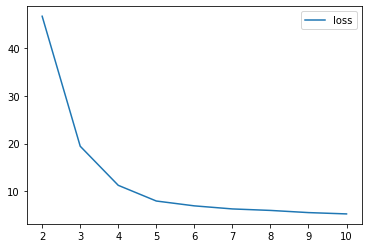

In [18]:
def show_loss(histories, without_first=False) :
    history =  []
    if without_first :
        history = histories[1:]
    else :
        history = histories
    fig, ax = plt.subplots()
    ax.plot([h['epoch'] for h in history], [h['loss'] for h in history], label='loss')
    plt.legend()
    plt.show()

def show_learning(histories, without_first=False):
    history =  []
    if without_first :
        history = histories[1:]
    else :
        history = histories
    fig, ax = plt.subplots()
    ax.plot([h['epoch'] for h in history], [h['train_acc'] for h in history], label='train accuracy')
    ax.plot([h['epoch'] for h in history], [h['valid_acc'] for h in history], label='test accuracy')
    plt.legend()
    plt.show()
    
show_loss(history, True)


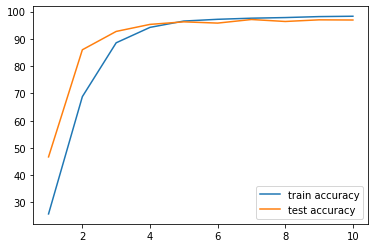

In [19]:
show_learning(history, False)

<p>Il serait intéressant de pouvoir obtenir le taux d'apprentissage par classe, pour observer l'apprentissage de notre modèle. Nous allons utiliser une autre librairie que torch pour faire ceci : sklearn. Cette librairie nous propose un rapport de classification avec diverses métrics intéressantes (notamment le f1_score)<p/>

In [20]:
def get_metrics(data_loader, model):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data_loader):
        
        output = model(images.view(-1, 3, 32, 32)).argmax(1)
        #print(output)
        predictions = []

        for prediction in output.tolist() :
            predictions.append(raw_data.classes[prediction])
        for i in range(len(predictions)) :
            y_pred.append(int(predictions[i]))
            y_true.append(int(labels[i]))
            
    return y_pred, y_true

y_pred, y_true = get_metrics(test_dataloader, net)

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=CLASSES.values()))


                                                                              precision    recall  f1-score   support

                                              Limitation de vitesse (20km/h)       1.00      1.00      1.00        60
                                              Limitation de vitesse (30km/h)       0.95      0.99      0.97       720
                                              Limitation de vitesse (50km/h)       0.95      1.00      0.97       750
                                              Limitation de vitesse (60km/h)       0.94      0.98      0.96       450
                                              Limitation de vitesse (70km/h)       0.99      0.99      0.99       660
                                              Limitation de vitesse (80km/h)       0.98      0.95      0.97       630
                                       Fin de limitation de vitesse (80km/h)       1.00      0.90      0.95       150
                                             Limitation

## En conclusion

<p>Notre modèle n'est pas le plus optimisé, on peut voir qu'il apprend beaucoup moins bien sur certaines classes, le plus souvent celles en sous-nombre.
Pour pallier à ce problème nous voyons trois solutions : 
<li>réorganiser le jeu de données pour qu'il puisse correspondre au maximum à la parité du jeu de test.
<li>totalement changer le traitement des données afin de plus avoir de triplets rgb mais transformer les images en noir et blanc.
<li>utiliser les données du csv Roi pour avoir les différences précises dans l'image.<p/>
<p>Ici, nous allons essayer la deuxième option, rapidement, pour voir si cela change quelque chose.<p/>

In [22]:
# on commence par recolter les donnees et transformer les images en tensors
raw_data_gr = datasets.ImageFolder("panneaux_route/Train", transform=transforms.Compose(
    [   transforms.Grayscale(num_output_channels=1),
        transforms.Resize((32,32)),
        transforms.ToTensor()
    ]
))

# construisons le dataloader
train_loader_gr = DataLoader(raw_data_gr, batch_size=256, shuffle=True)

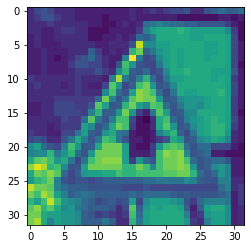

Intersection ou' vous etes prioritaire


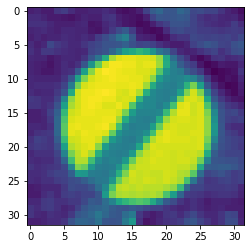

Fin des interdictions precedemment signalees


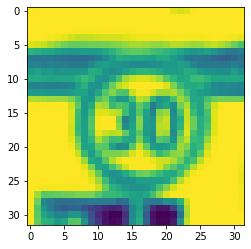

Limitation de vitesse (30km/h)


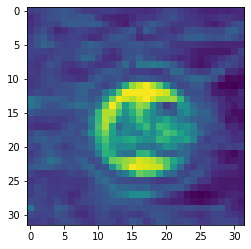

Limitation de vitesse (60km/h)


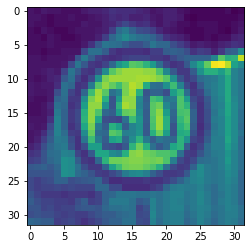

Limitation de vitesse (60km/h)


In [23]:
for images, labels in train_loader_gr :
    for i in range(5) :
        plt.imshow(images[i].permute(1,2,0))
        plt.show()
        print(CLASSES[int(raw_data.classes[labels[i]])]) # pour palier au probleme d'ordre des classes voici ce que nous devons faire
    break

In [24]:
df = pd.read_csv('panneaux_route/Test.csv', sep=',')
transformation = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.Resize((32,32)), transforms.ToTensor()])

labels = list(df['ClassId'])
images = list(df['Path'])
img_lst = []

for img in images :
    img = "panneaux_route/" + img
    img_lst.append(transformation(Image.open(img)))

In [25]:
# le dataset
test_dataset_gr = MyDataSet(img_lst, labels)

# le dataloader
test_dataloader_gr = DataLoader(test_dataset_gr, batch_size=256)

In [26]:
def validate_test_gr(data_loader, model):
    nb_errors = 0
    nb_tests = 0
    for i, (images, labels) in enumerate(data_loader):
        output = model(images.view(-1, 1, 32, 32)).argmax(1)
        predictions = []
        for prediction in output.tolist() :
            predictions.append(raw_data.classes[prediction])

        for i in range(len(predictions)) :
            if int(predictions[i]) != int(labels[i]) :
                nb_errors += 1
        nb_tests += len(images)
    
    return (100*(nb_tests-nb_errors)) / nb_tests

In [27]:
def train_loop_gr(train_loader, model, loss_map, lr=1e-3, epochs=20, weight_decay=0) :
    history = []    #for monitoring

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # nous utilisons l'optimiseur Adam vu en cours

    # boucle d'apprentissage
    for epoch in range(epochs) :
        loss_epoch = 0.
        train_acc = 0.

        model.train()

        for images, labels in train_loader :
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_map(output, labels)

            model.zero_grad()
            loss.backward()
            optimizer.step()

            loss_epoch += loss.item()
            train_acc += validate_normal(output, labels)

        # affichage des differents epochs
        model.eval()
        test_acc = validate_test_gr(test_dataloader_gr, model)
        train_acc = 100*train_acc/len(train_loader.dataset)
        history.append(
            {'epoch' : epoch + 1,
             'loss' : loss_epoch,
             'train_acc' : train_acc,
             'valid_acc' : test_acc})
        print(f"epoch : {epoch + 1}/{epochs}, loss = {loss_epoch:.6f}, train_acc = {train_acc}, test_acc = {test_acc}%")
    return history

In [28]:
net_gr = LeNet5(0, 1)

total_nb_par = 0
for p in net_gr.parameters():
    total_nb_par += reduce(lambda x, y: x*y, p.shape, 1)
print("total nb parameters: ", total_nb_par)

total nb parameters:  180815


cpu
epoch : 1/10, loss = 425.181040, train_acc = 28.786758142263256, test_acc = 77.54552652414885%
epoch : 2/10, loss = 93.963205, train_acc = 84.81726134305899, test_acc = 92.09817893903404%
epoch : 3/10, loss = 50.887416, train_acc = 92.77716850723048, test_acc = 94.59224069675376%
epoch : 4/10, loss = 38.326804, train_acc = 95.22303552755744, test_acc = 96.00950118764845%
epoch : 5/10, loss = 34.110610, train_acc = 95.94225815501542, test_acc = 95.36817102137768%
epoch : 6/10, loss = 31.351010, train_acc = 96.4829503430335, test_acc = 95.41567695961996%
epoch : 7/10, loss = 28.494428, train_acc = 97.04404600984468, test_acc = 95.93032462391132%
epoch : 8/10, loss = 29.379790, train_acc = 96.78390165523221, test_acc = 96.46872525732383%
epoch : 9/10, loss = 27.789174, train_acc = 97.11290775077151, test_acc = 96.57957244655582%
epoch : 10/10, loss = 26.071305, train_acc = 97.3500981917417, test_acc = 96.27870150435471%


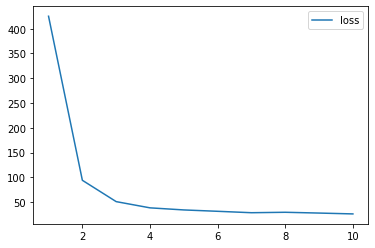

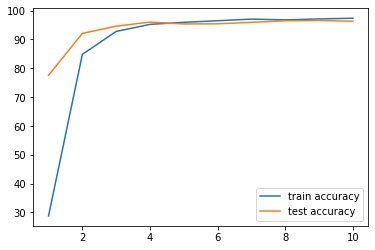

In [29]:
net_gr     = LeNet5(0.4, 1)
history = train_loop_gr(train_loader_gr, net_gr, nn.CrossEntropyLoss(), lr=0.00155, epochs=10, weight_decay=0.008)

show_loss(history)
show_learning(history)

In [30]:
def get_metrics_gr(data_loader, model):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data_loader):
        
        output = model(images.view(-1, 1, 32, 32)).argmax(1)
        #print(output)
        predictions = []

        for prediction in output.tolist() :
            predictions.append(raw_data.classes[prediction])
        for i in range(len(predictions)) :
            y_pred.append(int(predictions[i]))
            y_true.append(int(labels[i]))
            
    return y_pred, y_true
y_pred, y_true = get_metrics_gr(test_dataloader_gr, net_gr)
print(classification_report(y_true, y_pred, target_names=CLASSES.values()))

                                                                              precision    recall  f1-score   support

                                              Limitation de vitesse (20km/h)       1.00      0.97      0.98        60
                                              Limitation de vitesse (30km/h)       0.98      0.98      0.98       720
                                              Limitation de vitesse (50km/h)       0.99      0.98      0.98       750
                                              Limitation de vitesse (60km/h)       0.95      0.98      0.96       450
                                              Limitation de vitesse (70km/h)       0.97      0.99      0.98       660
                                              Limitation de vitesse (80km/h)       0.97      0.96      0.96       630
                                       Fin de limitation de vitesse (80km/h)       0.99      0.89      0.94       150
                                             Limitation

## Sauvegarde des models

In [31]:
torch.save(net.state_dict(), "model_rgb.pt")
torch.save(net_gr.state_dict(), "model_gr.pt")

## Résultat
<p>Nous avons observé que la réussite de notre modèle en nuances de gris ne changeait pas de beaucoup. Pourtant, l'idée n'est pas totalement à jeter. Après avoir arpenté les Internets, nous avons pu constater bons nombres de papiers de recherche sur le sujet, et généralement, les CNN préfèrent les images en nuances de gris. Dans notre cas précis, il fallait peut-être réduire les images directement à la taille des rois indiquées dans le .csv</p>